# Time Series Analysis with Recurrent Neural Networks (Keras)

1. Get Data
2. Explore Data
3. Clean and prepare data
4. Split into training and testing sets
5. Assemble Model
6. Train Model
7. Evaluate Model
8. Profit?

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7488475348807408690
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7193776729359587301
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

df = pd.read_csv('../Historical Data/TSLA.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2.556000e+03
mean,228.673478,233.456397,223.839930,228.849711,228.849711,6.180896e+06
std,228.656850,235.556115,222.185083,229.356548,229.356548,5.766879e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,35.270000,36.000000,34.740000,35.290001,35.290001,2.065050e+06
50%,219.680000,222.510002,215.449997,219.165001,219.165001,4.845600e+06
75%,291.079987,297.362488,284.729988,291.150001,291.150001,7.992825e+06
max,2044.760010,2095.489990,2025.050049,2049.979980,2049.979980,6.093880e+07


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 7 columns):
Date         2556 non-null object
Open         2556 non-null float64
High         2556 non-null float64
Low          2556 non-null float64
Close        2556 non-null float64
Adj Close    2556 non-null float64
Volume       2556 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 139.9+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2551,2020-08-17,1677.000000,1845.859985,1672.829956,1835.640015,1835.640015,20242300
2552,2020-08-18,1898.989990,1923.900024,1845.109985,1887.089966,1887.089966,16474500
2553,2020-08-19,1865.000000,1911.000000,1841.209961,1878.530029,1878.530029,12205300
2554,2020-08-20,1860.680054,2021.989990,1857.060059,2001.829956,2001.829956,20611800
2555,2020-08-21,2044.760010,2095.489990,2025.050049,2049.979980,2049.979980,21428800


## 2. Explore Data

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


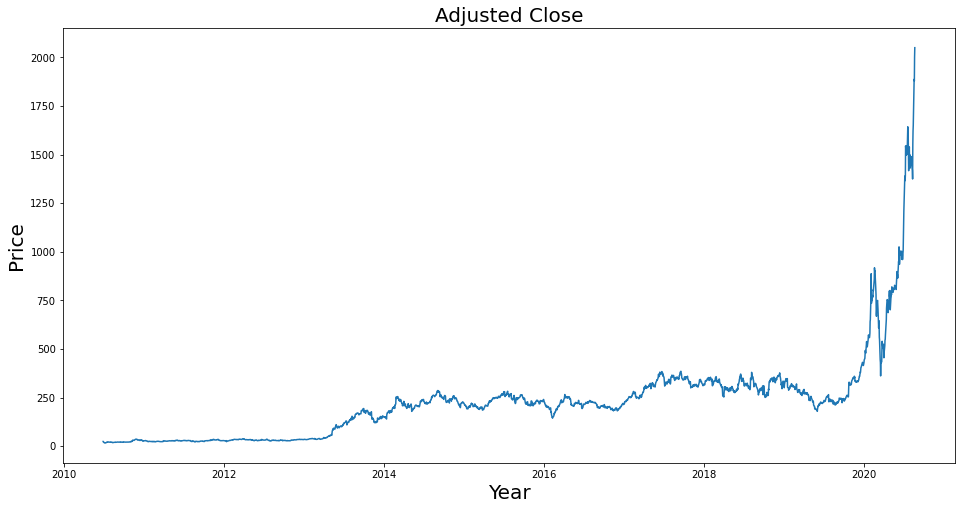

In [8]:
df['Date'] = pd.to_datetime(df['Date']) 
x = df.Date
Y = df['Adj Close']

plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close',fontsize=20)
plt.show()


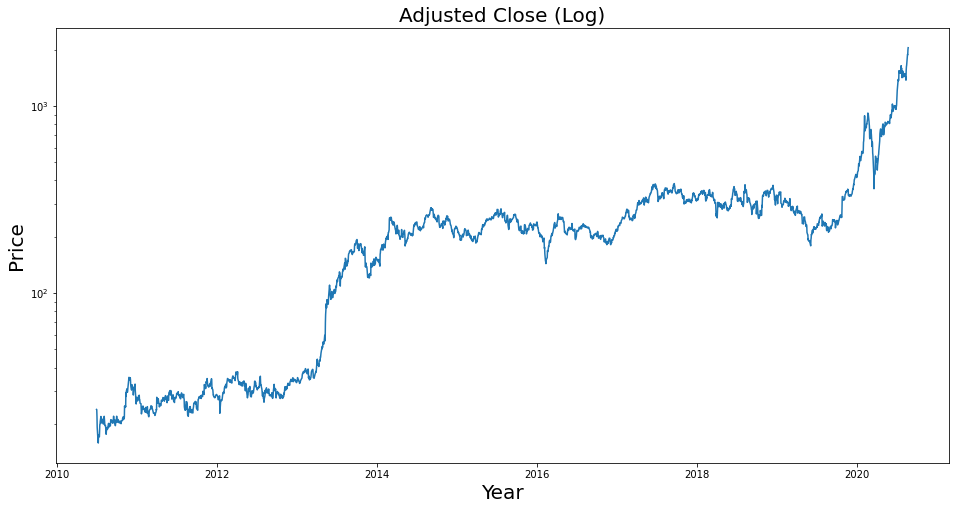

In [9]:
plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close (Log)',fontsize=20)
plt.yscale('log')
plt.show()

In [10]:
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']
df['Adj Volume'] = df['Volume']

data=df[['Adj Close','Adj Volume','Adj High','Adj Low']]
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low
0,23.889999,18766300,25.00,17.540001
1,23.830000,17187100,30.42,23.299999
2,21.959999,8218800,25.92,20.270000
3,19.200001,5139800,23.10,18.709999
4,16.110001,6866900,20.00,15.830000


## 3. Clean and Prepare Data

In [11]:
dataCopy = data.copy()

data.loc[:,('dailyReturn')] = np.log(dataCopy.loc[:,('Adj Close')]/dataCopy.loc[:,('Adj Close')].shift(1))
data.loc[:,'weeklyReturn'] = np.log(dataCopy.loc[:,'Adj Close']/dataCopy.loc[:,'Adj Close'].shift(5))
data.loc[:,'dailyHL'] = np.log(dataCopy.loc[:,'Adj High']/dataCopy['Adj Low'])
data.loc[:,'weeklyHL'] = np.log(dataCopy.loc[:,'Adj High'].rolling(6).max()/dataCopy.loc[:,'Adj Low'].rolling(6).min())
data.head(12)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
0,23.889999,18766300,25.000000,17.540001,NaN,NaN,0.354392,NaN
1,23.830000,17187100,30.420000,23.299999,-0.002515,NaN,0.266647,NaN
2,21.959999,8218800,25.920000,20.270000,-0.081723,NaN,0.245873,NaN
3,19.200001,5139800,23.100000,18.709999,-0.134312,NaN,0.210775,NaN
4,16.110001,6866900,20.000000,15.830000,-0.175470,NaN,0.233825,NaN
5,15.800000,6921700,16.629999,14.980000,-0.019430,-0.413450,0.104492,0.708384
6,17.459999,7711400,17.520000,15.570000,0.099903,-0.311033,0.117997,0.708384
7,17.400000,4050600,17.900000,16.549999,-0.003442,-0.232752,0.078415,0.548299
8,17.049999,2202500,18.070000,17.000000,-0.020320,-0.118760,0.061040,0.433117
9,18.139999,2680100,18.639999,16.900000,0.061969,0.118679,0.097996,0.289016


In [12]:
data = data.dropna(how='any')
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
5,15.800000,6921700,16.629999,14.980000,-0.019430,-0.413450,0.104492,0.708384
6,17.459999,7711400,17.520000,15.570000,0.099903,-0.311033,0.117997,0.708384
7,17.400000,4050600,17.900000,16.549999,-0.003442,-0.232752,0.078415,0.548299
8,17.049999,2202500,18.070000,17.000000,-0.020320,-0.118760,0.061040,0.433117
9,18.139999,2680100,18.639999,16.900000,0.061969,0.118679,0.097996,0.289016


In [13]:
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [14]:
n_trail = 5
n_lead = 5
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL']

reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.019430          -0.413450      0.104492       0.708384   
11          0.099903          -0.311033      0.117997       0.708384   
12         -0.003442          -0.232752      0.078415       0.548299   
13         -0.020320          -0.118760      0.061040       0.433117   
14          0.061969           0.118679      0.097996       0.289016   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.099903          -0.311033      0.117997       0.708384   
11         -0.003442          -0.232752      0.078415       0.548299   
12         -0.020320          -0.118760      0.061040       0.433117   
13          0.061969           0.118679      0.097996       0.289016   
14          0.089581           0.227690      0.126256       0.296488   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10         -0.003442          -0.232752  ...      0.06163

## 4. Split in Training and Testing Data

In [15]:
values = reframed.values

trainTestSplit = 0.75

mask = np.random.rand(len(values)) < trainTestSplit

train = values[mask,:]
test = values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign test and training sets
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1953, 44)
(1953, 24)
(1953, 6, 4) (1953, 16) (588, 6, 4) (588, 16)
(1953, 6, 4) (1953, 4) (588, 6, 4) (588, 4)


## 5. Assemble the Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0

In [17]:
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 6. Train the Model

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Train on 1953 samples, validate on 588 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_3622 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_3926 in d

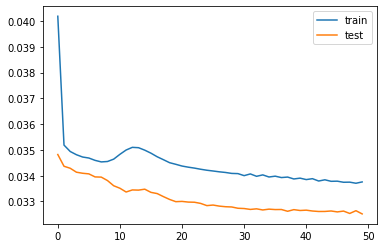

In [18]:
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. Evaluate the Model

In [19]:
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 'Predicted Weekly', 
                   'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_11614 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,0.013715,0.031007,0.003816,0.016311,0.051032,0.171587
1,-0.016099,-0.044804,0.005186,0.014829,0.047015,0.158315
2,0.047978,-0.001433,0.002969,0.003265,0.041198,0.122466
3,-0.031940,0.025728,0.000763,0.004493,0.034567,0.103544
4,-0.042964,-0.017709,0.001067,0.010351,0.032001,0.097150


In [20]:
results['Prop'] = results['Weekly Return']/results['Predicted Weekly']

results['Correct'] = results['Prop'].apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.09863945578231292
Direction Only Accuracy Score:  0.5476190476190477


In [21]:
np.corrcoef(results['Weekly Return'], results['Predicted Weekly'])

array([[1.        , 0.01766888],
       [0.01766888, 1.        ]])

In [22]:
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

print('Buy Signal: ', buySignal)
print('Sell Signal: ', sellSignal)

Buy Signal:  0.20007826443152182
Sell Signal:  0.03584668725248921


In [23]:
analyze = analyze[(analyze['Risk-Reward'] > buySignal) | (analyze['Risk-Reward'] <= sellSignal)]
print('Trade Signal x% of the time: ', analyze.shape[0]/results.shape[0])
analyze.head()

Trade Signal x% of the time:  0.10204081632653061


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL,Prop,Correct,Correct2,Risk-Reward
2,0.047978,-0.001433,0.002969,0.003265,0.041198,0.122466,-0.438922,0,0,0.026660
30,0.001876,0.009797,0.001189,0.034990,0.042944,0.148500,0.279980,0,1,0.235626
31,-0.018088,-0.092305,0.000394,0.003135,0.031652,0.092328,-29.440021,0,0,0.033959
54,0.044986,-0.128182,0.000455,0.002426,0.036147,0.110498,-52.841927,0,0,0.021953
56,-0.003243,0.070212,0.001156,0.029820,0.040373,0.139639,2.354486,0,1,0.213553


In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

X = analyze['Risk-Reward']
Y = analyze['Weekly Return']

X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

lr = LinearRegression()
lr = lr.fit(X,Y)
preds = lr.predict(X)

from sklearn.metrics import r2_score

print('R^2 Score: ', r2_score(Y,preds))

R^2 Score:  0.0044581889729382596


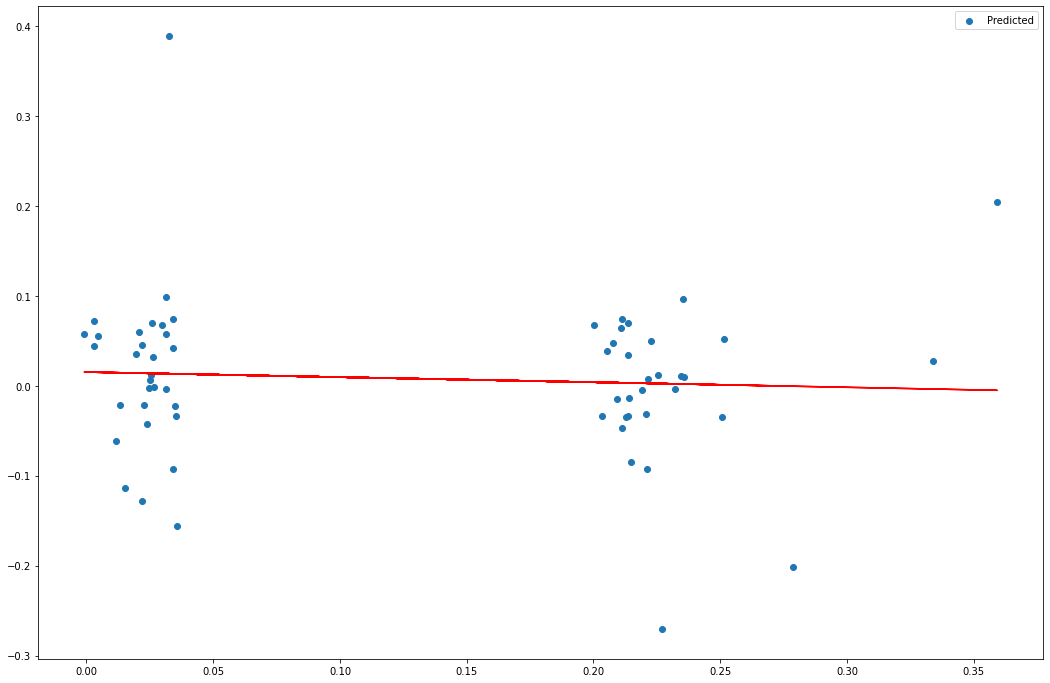

In [25]:
plt.figure(figsize=(18,12))
time = list(range(0,len(X)))
plt.scatter(X,Y,label='Predicted')
plt.plot(X,preds,color='r')
plt.legend()
plt.show()

## 8. Profit?

In [26]:
portfolio = [1000]
hodl = [1000]
bpFee = 20
feeModifier = 1 - (bpFee / 10000)

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal:
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal:
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1]
    portfolio.append(today)
    
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  -5.753294760564498 %


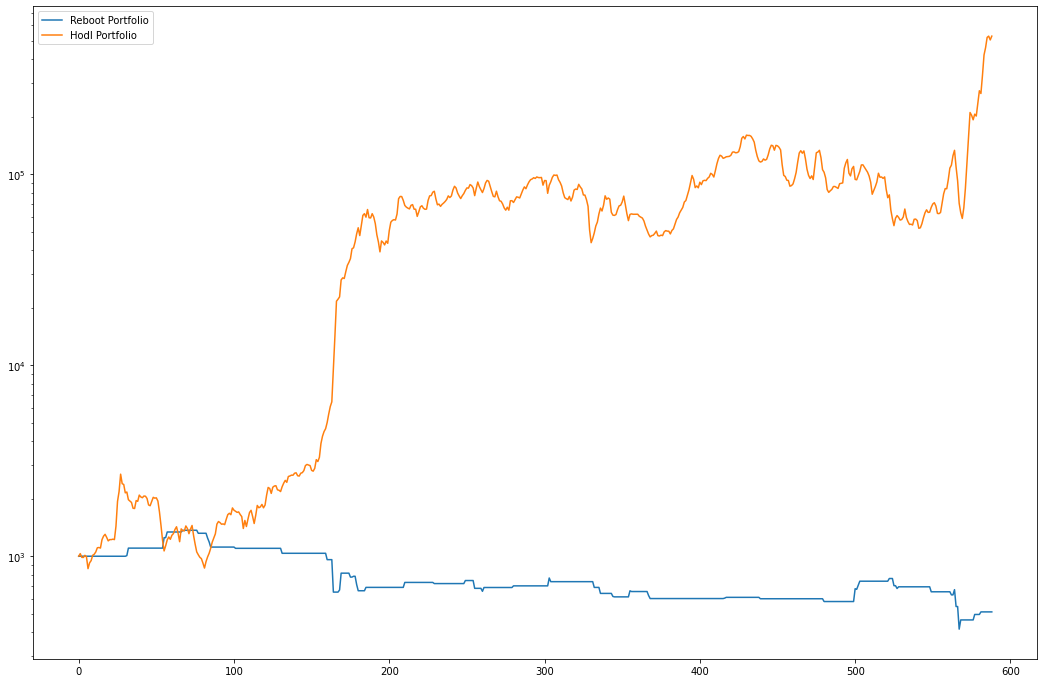

In [27]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.yscale('log')
plt.show()

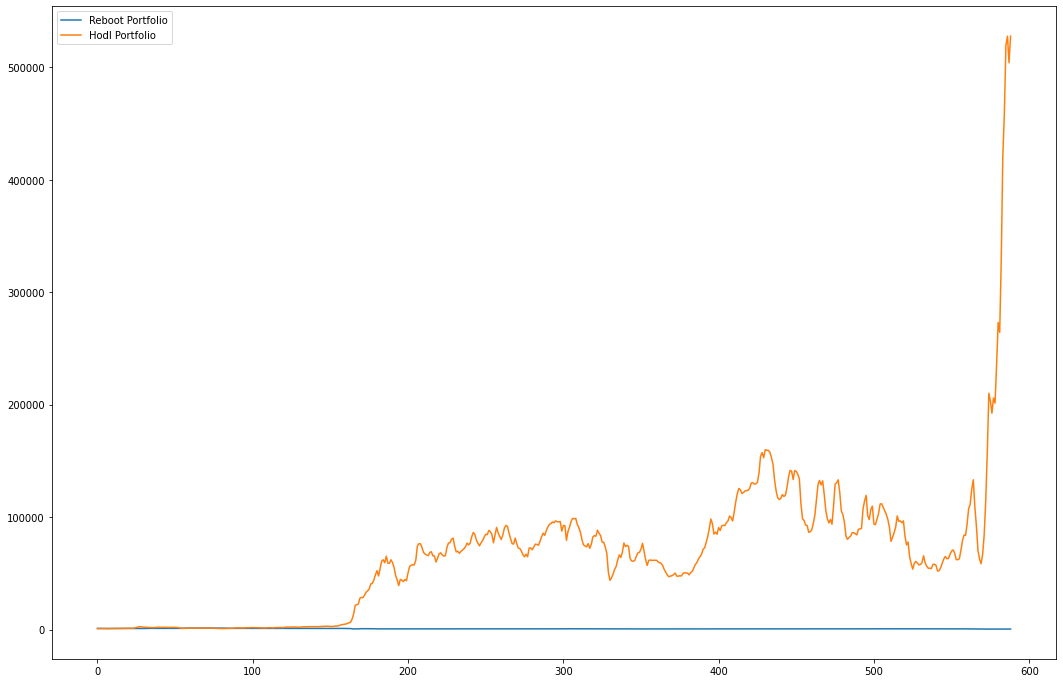

In [28]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.show()

In [30]:
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'TSLA'
# port_df = port_df.head(len(df[::4].Date.tolist()))
port_df['Date'] = df[::4].head(port_df.shape[0]).Date.tolist()

port_df = port_df[['Date','portfolio','hodl','symbol']]
port_df.to_csv('../Results Data/TSLA_results.csv',index=False)
port_df

,Date,portfolio,hodl,symbol
0,2010-06-29,1000.000000,1000.000000,TSLA
1,2010-07-06,1000.000000,1031.492346,TSLA
2,2010-07-12,1000.000000,986.296928,TSLA
3,2010-07-16,999.431214,984.884523,TSLA
4,2010-07-22,999.431214,1010.552411,TSLA
...,...,...,...,...
584,2019-10-09,511.110688,459210.629538,TSLA
585,2019-10-15,511.110688,519770.570889,TSLA
586,2019-10-21,511.110688,527744.611596,TSLA
587,2019-10-25,511.110688,504136.461396,TSLA
